# Predicting the power consumption trend

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
data = pd.read_csv('D202.csv')
data

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


The data shows each time there is a power consumption with start time and end time. We are only interested in total daily consumption. Also, there are a lot of columns which are not required

## Cleaning the data

In [50]:
data.drop('NOTES', axis = 1, inplace = True)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.8+ MB


In [52]:
data.isnull().any()  #checking for null

TYPE          False
DATE          False
START TIME    False
END TIME      False
USAGE         False
UNITS         False
COST          False
dtype: bool

In [54]:
y= data['USAGE'].values
X= np.arange(y.shape[0])

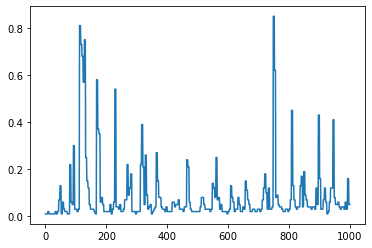

In [55]:
plt.plot(X[:1000],y[:1000])

In [56]:
df2 = data.copy(deep = True)
df2.drop(columns = ['START TIME','END TIME','UNITS','COST','TYPE'], inplace =True)


In [57]:
df2

,DATE,USAGE
0,10/22/2016,0.01
1,10/22/2016,0.01
2,10/22/2016,0.01
3,10/22/2016,0.01
4,10/22/2016,0.01
...,...,...
70363,10/24/2018,0.02
70364,10/24/2018,0.03
70365,10/24/2018,0.03
70366,10/24/2018,0.03


### Grouping the power consumption date-wise

In [58]:
print(type(df2.DATE[0]))

<class 'str'>


In [59]:
df2['DATE'] = pd.to_datetime(df2['DATE'])

In [60]:
print(type(df2.DATE[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [61]:
group_days = df2.groupby('DATE')

In [62]:
df3 = group_days.sum()

In [63]:
df3

,USAGE
DATE,
2016-10-22,4.52
2016-10-23,23.32
2016-10-24,7.16
2016-10-25,8.68
2016-10-26,5.04
...,...
2018-10-20,8.00
2018-10-21,1.12
2018-10-22,0.64


In [64]:
df3.sort_values(by='DATE')
df3

,USAGE
DATE,
2016-10-22,4.52
2016-10-23,23.32
2016-10-24,7.16
2016-10-25,8.68
2016-10-26,5.04
...,...
2018-10-20,8.00
2018-10-21,1.12
2018-10-22,0.64


C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='USAGE', ylabel='Density'>

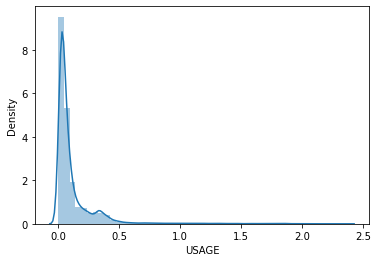

In [65]:
sns.distplot(data['USAGE'])

## Plotting the data

In [66]:
y= df3['USAGE'].values
X= np.arange(y.shape[0])

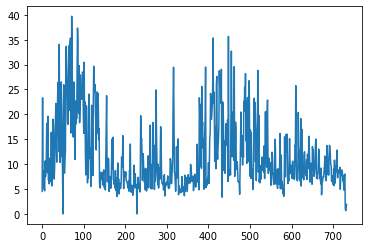

In [67]:
plt.plot(X,y,'-',label="Test data")
plt.xlabel('Days')
plt.ylabel('Power consumption (kW)')
plt.title('Training data')
plt.legend()
plt.show()

### Splitting the data
Using the split at 365 days to capture yearly trend

In [ ]:
# Define the split time
split_time = 365

# Get the train set 
x_train = y[:split_time]
time_train = X[:split_time]

# Get the validation set
x_valid = y[split_time:]
time_valid = X[split_time:]

Preparing the dataset

In [69]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [70]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 100

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Model

In [71]:
# Build the Model
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0

Finding best learning rate using callbacks

In [72]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()      #SGD(momentum=0.9)

# Set the training parameters
model1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model1.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
11/11 [==============================] - 45s 43ms/step - loss: 48.1774 - lr: 1.0000e-08
Epoch 2/100
11/11 [==============================] - 0s 23ms/step - loss: 48.1697 - lr: 1.1220e-08
Epoch 3/100
11/11 [==============================] - 0s 28ms/step - loss: 48.1609 - lr: 1.2589e-08
Epoch 4/100
11/11 [==============================] - 0s 26ms/step - loss: 48.1512 - lr: 1.4125e-08
Epoch 5/100
11/11 [==============================] - 0s 21ms/step - loss: 48.1410 - lr: 1.5849e-08
Epoch 6/100
11/11 [==============================] - 0s 29ms/step - loss: 48.1299 - lr: 1.7783e-08
Epoch 7/100
11/11 [==============================] - 0s 25ms/step - loss: 48.1177 - lr: 1.9953e-08
Epoch 8/100
11/11 [==============================] - 0s 23ms/step - loss: 48.1036 - lr: 2.2387e-08
Epoch 9/100
11/11 [==============================] - 0s 38ms/step - loss: 48.0873 - lr: 2.5119e-08
Epoch 10/100
11/11 [==============================] - 0s 26ms/step - loss: 48.0686 - lr: 2.8184e-08
Epoch 11

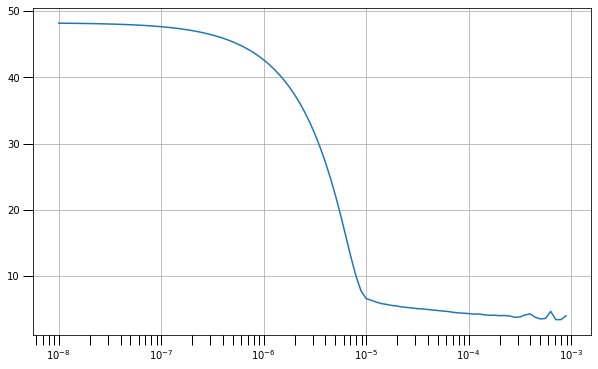

In [74]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
#plt.axis([1e-8, 1e-3, 0, 30])

In [78]:
tf.keras.backend.clear_session()

In [79]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)   #taking the learning rate from the above figure
model1.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
               metrics = ['mae']
              )

In [80]:
history = model1.fit(train_set,epochs=100)

Epoch 1/100
11/11 [==============================] - 23s 30ms/step - loss: 3.3856 - mae: 3.8467
Epoch 2/100
11/11 [==============================] - 0s 29ms/step - loss: 3.2420 - mae: 3.7012
Epoch 3/100
11/11 [==============================] - 0s 24ms/step - loss: 3.1901 - mae: 3.6424
Epoch 4/100
11/11 [==============================] - 0s 41ms/step - loss: 3.2802 - mae: 3.7448
Epoch 5/100
11/11 [==============================] - 0s 23ms/step - loss: 3.2052 - mae: 3.6640
Epoch 6/100
11/11 [==============================] - 0s 24ms/step - loss: 3.2268 - mae: 3.6810
Epoch 7/100
11/11 [==============================] - 0s 41ms/step - loss: 3.2762 - mae: 3.7310
Epoch 8/100
11/11 [==============================] - 0s 25ms/step - loss: 3.2902 - mae: 3.7499
Epoch 9/100
11/11 [==============================] - 0s 28ms/step - loss: 3.3488 - mae: 3.8198
Epoch 10/100
11/11 [==============================] - 0s 39ms/step - loss: 3.2395 - mae: 3.7039
Epoch 11/100
11/11 [============================

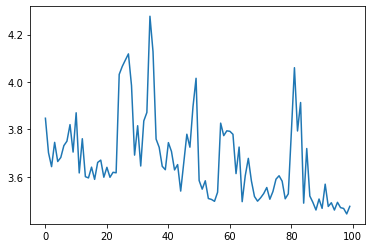

In [81]:
plt.plot(history.history['mae'])

## Forecasting on test data

In [82]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [83]:
forecast_series = y[split_time-window_size:-1]

In [84]:
forecast = model_forecast(model1, forecast_series, window_size, batch_size)

In [85]:
forecast.shape

(368, 1)

## Plotting results

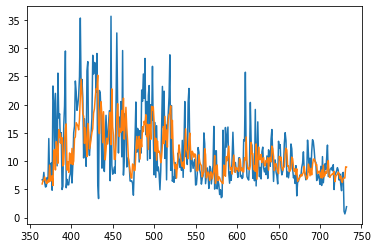

In [86]:
results = forecast.squeeze()
plt.plot(time_valid,x_valid,label="Test data")
plt.plot(time_valid,results,label="Predicted value")
plt.xlabel('Days')
plt.ylabel('Power consumption (kW)')
plt.title('Test vs Predicted data')
plt.legend()
plt.show()

In [87]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

3.790684
